In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.io import fits
import geo 
import sys
sys.path.insert(0,"./jackknife/")
sys.path.insert(0,"./d-jackknife/")
from corr import lensingPCF
from corrd import deleted_jackknife
from scipy.interpolate import splrep,splev,interp1d
rng = np.random.default_rng()
import treecorr


In [2]:
df = Table.read("/feynman/work/dap/lceg/rp269101/stuff/BOSS_CMASS_flagship_2.10.fits")
df = df.to_pandas()
ra = df.ra.values
dec = df.dec.values
z = df.z.values
w = df.w.values
g1 = df.g1.values
g2 = df.g2.values

In [3]:
subsample = len(df)/2.
index = df.index.values
rng.shuffle(index)
df = df.iloc[index[0:int(subsample)]]
ra2 = df.ra.values
dec2 = df.dec.values
z2 = df.z.values
w2 = df.w.values
g12 = df.g1.values
g22 = df.g2.values

del df

In [4]:
"""Z-range within witch the sample was constructed"""
NSIDE = 256
Xmin = 0.4
Xmax = 0.8

"""Build random and get n(z) for modelling"""

footprint = geo.survey_geometry(NSIDE=NSIDE,RA=ra,DEC=dec)
footprint.set_target_nz(Z=z,W=w,xmin=Xmin,xmax=Xmax)
ra_rand,dec_rand,z_rand,w_rand = footprint.create_random_easy(size_random=int(len(ra)*10),shuf=True)
center,edges,dn,nz = footprint.compute_nz()
edges_high = edges[:-1]
edges_low = edges[1:]
np.savetxt("nz_CMASS_fs2.dat",np.transpose([edges_low,edges_high,center,dn]))

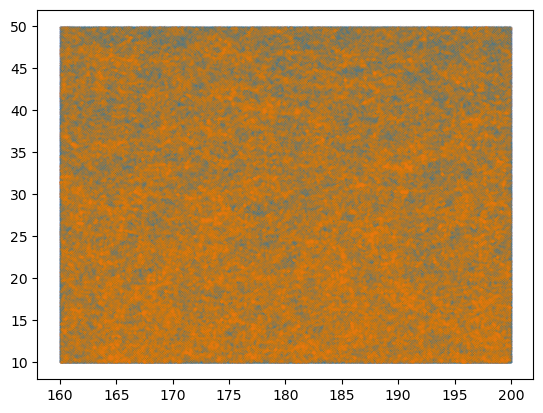

In [5]:
plt.scatter(ra_rand,dec_rand,s=0.0001)
plt.scatter(ra,dec,s=0.001)

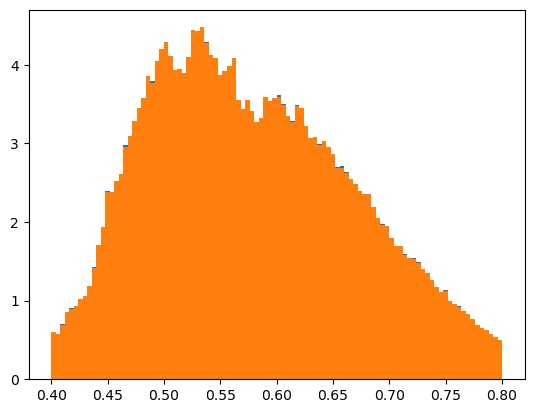

In [6]:
_=plt.hist(z,bins=100,density=True)
_=plt.hist(z_rand,bins=100,density=True)

Lets first compute projected measurements with a single patch, if no qwargs are arguments are provided, the bin_slop is set to 0.0 in the pipeline.


In [7]:
rpbins = np.geomspace(1e-1,10,13)
pibins = np.linspace(-80,80,17)

In [8]:
corr = lensingPCF(Om0=0.319,computation="WGP",binsfile=[rpbins,pibins],RA=ra,DEC=dec,Z=z,W=w,RA2=ra,DEC2=dec,Z2=z,W2=w,g1=g1,g2=g2,\
                  RA_r = ra_rand,DEC_r=dec_rand,Z_r=z_rand,W_r=w_rand,units="deg",npatch=1)

corr2 = lensingPCF(Om0=0.319,computation="WGG",binsfile=[rpbins,pibins],RA=ra,DEC=dec,Z=z,W=w,RA2=ra,DEC2=dec,Z2=z,W2=w,g1=g1,g2=g2,\
                  RA_r = ra_rand,DEC_r=dec_rand,Z_r=z_rand,W_r=w_rand,units="deg",npatch=1)


In [9]:
%%time
r,wgp_b,err = corr.get_measurements()
r2,wgg_b,err2 = corr2.get_measurements()


CPU times: user 1h 40min 35s, sys: 9.98 s, total: 1h 40min 45s
Wall time: 5min 20s


In [10]:
corr = lensingPCF(Om0=0.319,computation="WGP",binsfile=[rpbins,pibins],RA=ra,DEC=dec,Z=z,W=w,RA2=ra,DEC2=dec,Z2=z,W2=w,g1=g1,g2=g2,\
                  RA_r = ra_rand,DEC_r=dec_rand,Z_r=z_rand,W_r=w_rand,units="deg",npatch=50)

corr2 = lensingPCF(Om0=0.319,computation="WGG",binsfile=[rpbins,pibins],RA=ra,DEC=dec,Z=z,W=w,RA2=ra,DEC2=dec,Z2=z,W2=w,g1=g1,g2=g2,\
                  RA_r = ra_rand,DEC_r=dec_rand,Z_r=z_rand,W_r=w_rand,units="deg",npatch=50)



In [11]:
%%time
r_,wgp_jk,cov_jk = corr.get_measurements()
r2_,wgg_jk,cov2_jk = corr2.get_measurements()

CPU times: user 4h 10min 34s, sys: 4min 25s, total: 4h 15min
Wall time: 14min 55s


The deleted_jaccknife methods uses the package Corrfunc, to compute all clustering quantities, and which fasten a lot the computation. We use the version of Corrfunc implemented in pycorr.
The jackknife patches are defined with Treecorr.

In [25]:

corr = deleted_jackknife(Om0=0.319,computation="WGP",binsfile=[rpbins,pibins],Ns=10,Nd=6,RA=ra,DEC=dec,Z=z,W=w,g1=g1,g2=g2,\
                 RA_r = ra_rand,DEC_r=dec_rand,Z_r=z_rand,W_r=w_rand)


corr2 = deleted_jackknife(Om0=0.319,computation="WGG",binsfile=[rpbins,pibins],Ns=10,Nd=6,RA=ra,DEC=dec,Z=z,W=w,g1=g1,g2=g2,\
                 RA_r = ra_rand,DEC_r=dec_rand,Z_r=z_rand,W_r=w_rand)

In [26]:
%%time
r_,wgp_djk,cov_djk = corr.get_measurements()
r2_,wgg_djk,cov2_djk = corr2.get_measurements()

CPU times: user 55min 10s, sys: 4.64 s, total: 55min 15s
Wall time: 6min 14s


In [36]:
err_jk_wgp = np.sqrt(np.diag(cov_jk))
err_jk_wgg = np.sqrt(np.diag(cov2_jk))
err_djk_wgp = np.sqrt(np.diag(cov_djk))
err_djk_wgg = np.sqrt(np.diag(cov2_djk))

Let's plot the results:


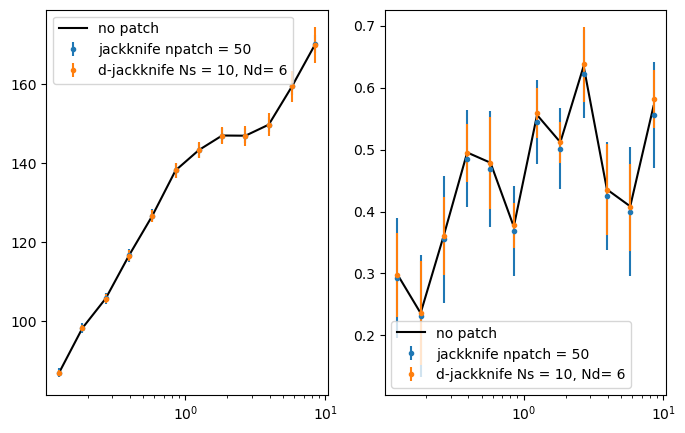

In [53]:
fig,ax = plt.subplots(1,2,figsize=(8,5))
ax[0].set_xscale('log')

ax[0].plot(r,wgg_b*r,color='black',label='no patch')
ax[0].errorbar(r,wgg_jk*r,yerr=err_jk_wgg*r,fmt=".",label='jackknife npatch = 50')
ax[0].errorbar(r,wgg_djk*r,yerr=err_djk_wgg*r,fmt=".",label='d-jackknife Ns = 10, Nd= 6')
ax[0].legend()

ax[1].set_xscale('log')

ax[1].plot(r,wgp_b*r,color='black',label='no patch')
ax[1].errorbar(r,wgp_jk*r,yerr=err_jk_wgp*r,fmt=".",label='jackknife npatch = 50')
ax[1].errorbar(r,wgp_djk*r,yerr=err_djk_wgp*r,fmt=".",label='d-jackknife Ns = 10, Nd= 6')

ax[1].legend()

And the covariance matrices